<a href="https://colab.research.google.com/github/YKochura/rl-kpi/blob/main/tutor/mf-prediction/RL_Model_Free_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Agents behaviors


- author: Miguel Morales
- book: [Grokking Deep Reinforcement Learning]


In [ ]:
#collapse
!pip install tqdm numpy scikit-learn pyglet setuptools && \
!pip install gym asciinema pandas tabulate tornado==5.* PyBullet && \
!pip install git+https://github.com/pybox2d/pybox2d#egg=Box2D && \
!pip install git+https://github.com/mimoralea/gym-bandits#egg=gym-bandits && \
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk && \
!pip install git+https://github.com/mimoralea/gym-aima#egg=gym-aima && \
!pip install gym[atari]

/bin/bash: !pip: command not found
  Cloning https://github.com/mimoralea/gym-bandits to /tmp/pip-install-2t_1phk3/gym-bandits_f09126d1c01343f38288652fa5c13eb7
  Running command git clone -q https://github.com/mimoralea/gym-bandits /tmp/pip-install-2t_1phk3/gym-bandits_f09126d1c01343f38288652fa5c13eb7
  Created wheel for gym-bandits: filename=gym_bandits-0.1-py3-none-any.whl size=5251 sha256=3f7733625a1658f7413c00c9a76e2d9da22bb26842c7b29028849d3784409a56
  Stored in directory: /tmp/pip-ephem-wheel-cache-o5v0yy0_/wheels/94/82/17/009e6f9dee410498c09cb6bb93eaa57df70c5f7da56b403ba4
Successfully built gym-bandits
/bin/bash: line 2: \: command not found
  Cloning https://github.com/mimoralea/gym-walk to /tmp/pip-install-qr3bzvju/gym-walk_4e560588f7ac46cfabb8cb04ba182a5e
  Running command git clone -q https://github.com/mimoralea/gym-walk /tmp/pip-install-qr3bzvju/gym-walk_4e560588f7ac46cfabb8cb04ba182a5e
  Created wheel for gym-walk: filename=gym_walk-0.0.1-py3-none-any.whl size=3808 sha256

## On-policy first-visit MC prediction, on-policy every-visit MC prediction, TD, n-step TD, TD(λ)

In [ ]:
import warnings ; warnings.filterwarnings('ignore')

import gym, gym_walk, gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [ ]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

### helper function

In [ ]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [ ]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [ ]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [ ]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [ ]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, _, done, h = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

In [ ]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [ ]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [ ]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [ ]:
def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]
    
    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y, 
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

In [ ]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

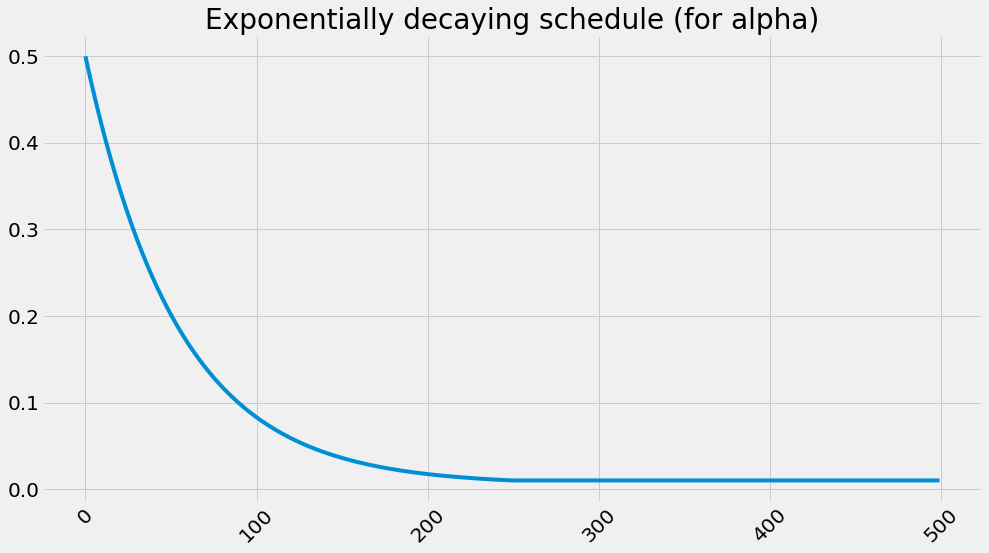

In [ ]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

### Random walk/Deterministic walk with uniformly random policy

In [ ]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.env.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 53.00%. Obtains an average return of 0.5300.


### First-visit Monte-Carlo prediction

In [ ]:
def generate_trajectory(pi, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, np.object)

In [ ]:
def mc_prediction(pi, 
                  env, 
                  gamma=1.0,
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.5,
                  n_episodes=500, 
                  max_steps=200,
                  first_visit=True):
    nS = env.observation_space.n
    discounts = np.logspace(0, 
                            max_steps, 
                            num=max_steps, 
                            base=gamma, 
                            endpoint=False)
    alphas = decay_schedule(init_alpha, 
                            min_alpha, 
                            alpha_decay_ratio, 
                            n_episodes)
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, 
                                         env, 
                                         max_steps)
        visited = np.zeros(nS, dtype=np.bool)
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if visited[state] and first_visit:
                continue
            visited[state] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            targets[state].append(G)
            mc_error = G - V[state]
            V[state] = V[state] + alphas[e] * mc_error
        V_track[e] = V
    return V.copy(), V_track, targets

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_fvmc, P, n_cols=7)
print()
print_state_value_function(V_fvmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
|           | 01  0.172 | 02  0.338 | 03  0.509 | 04  0.671 | 05  0.822 |           |

State-value function errors:
|           | 01  0.005 | 02  0.005 | 03  0.009 | 04  0.004 | 05 -0.011 |           |
RMSE: 0.006


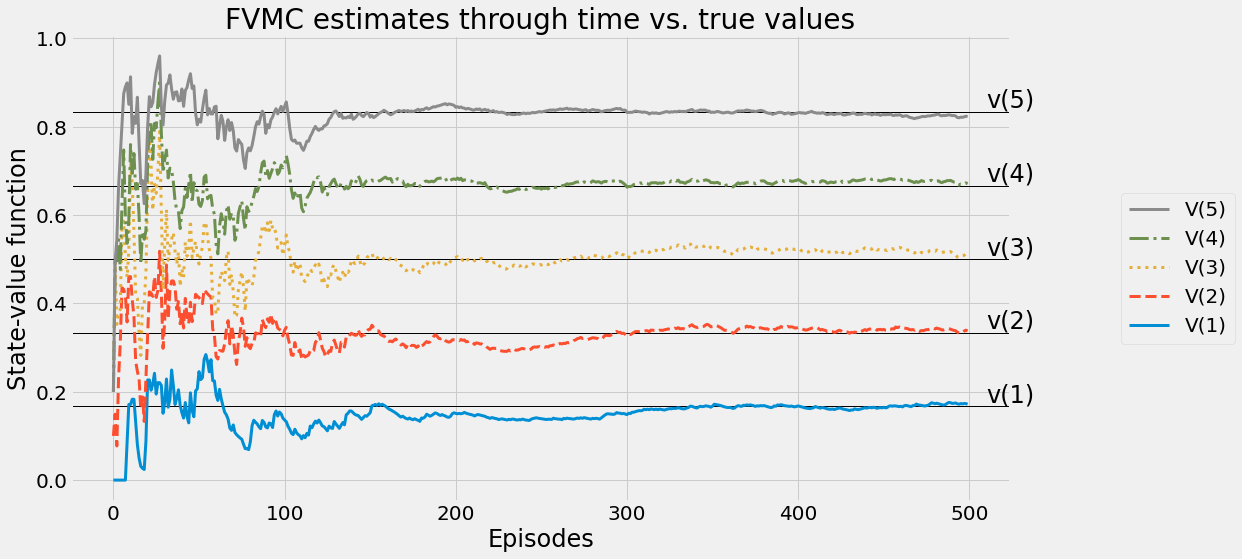

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

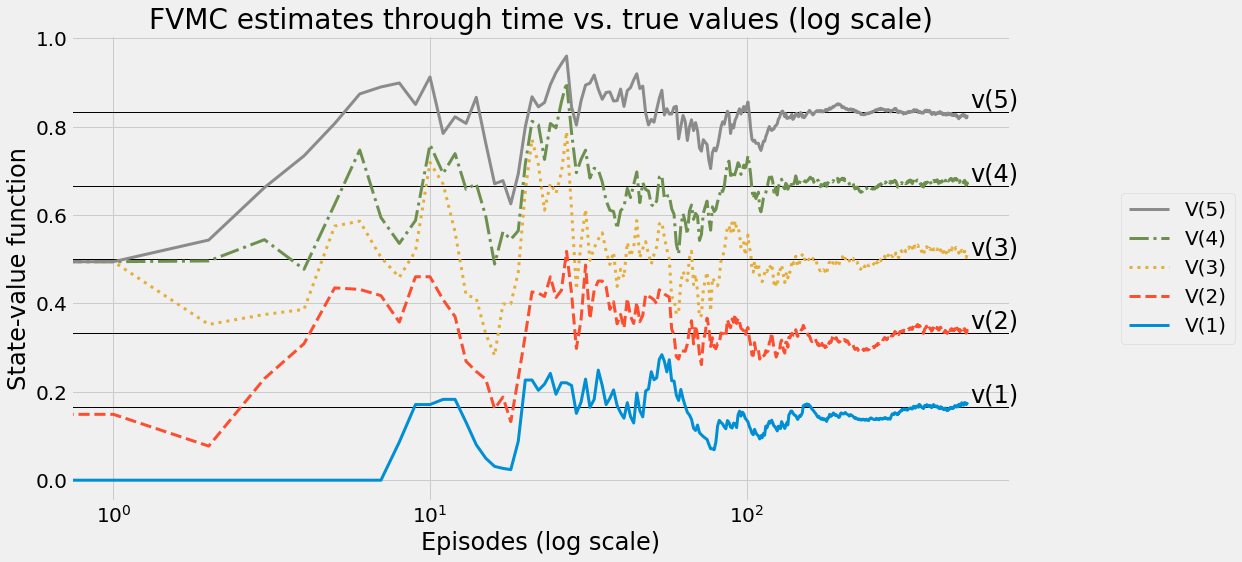

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

#### Every-visit Monte-Carlo prediction

In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_evmc, P, n_cols=7)
print()
print_state_value_function(V_evmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
|           | 01  0.179 | 02  0.377 | 03  0.549 | 04  0.692 | 05   0.83 |           |

State-value function errors:
|           | 01  0.013 | 02  0.044 | 03  0.049 | 04  0.026 | 05 -0.004 |           |
RMSE: 0.0271


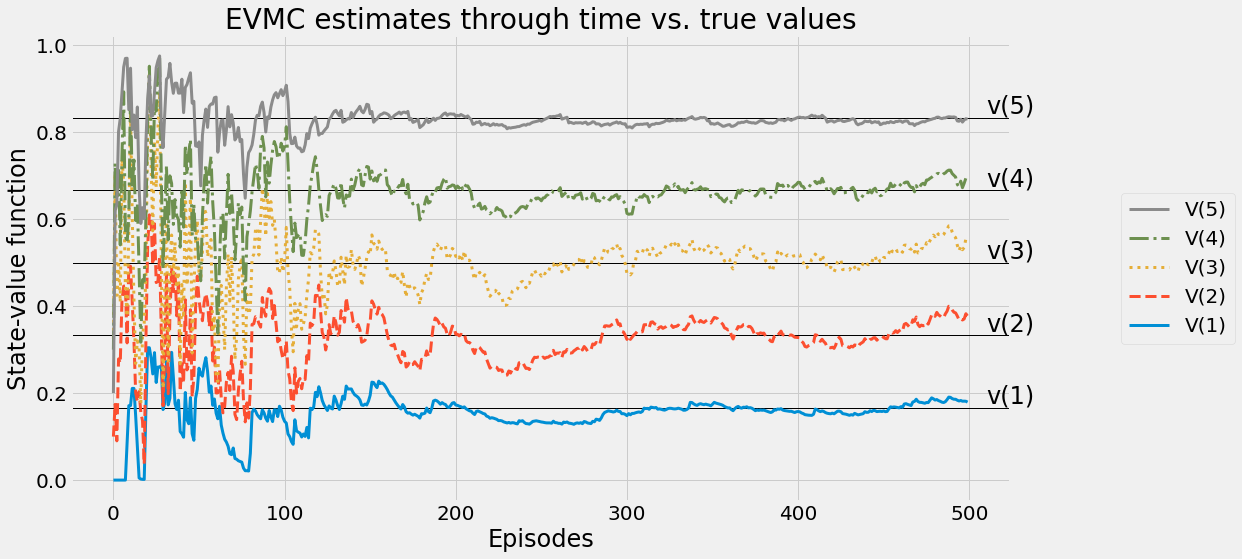

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

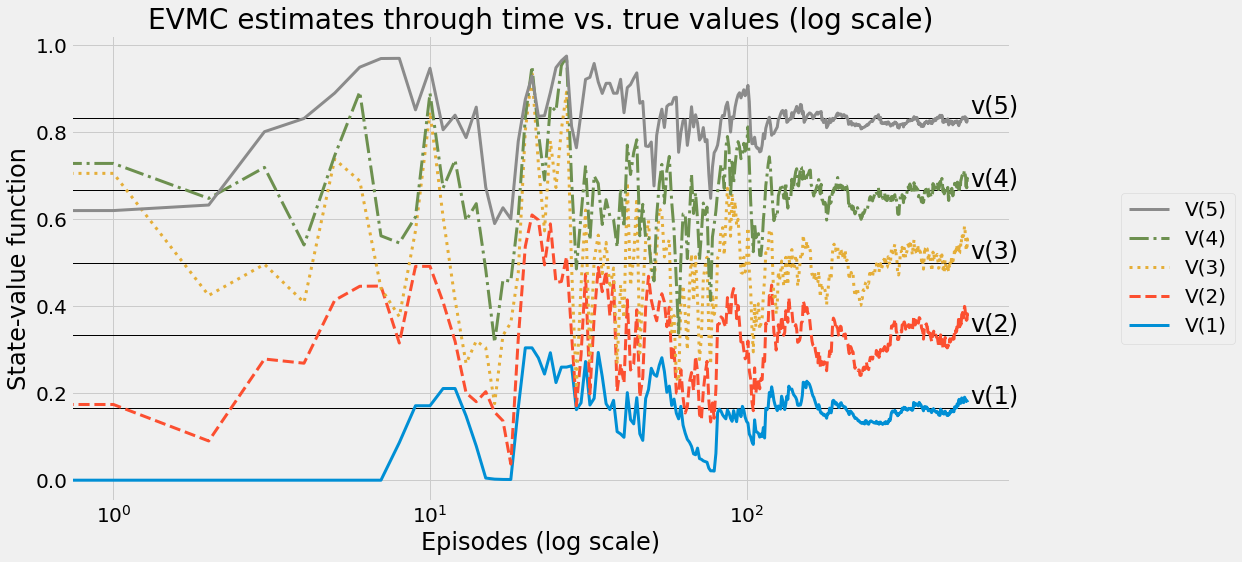

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

#### Temporal-Difference Prediction (TD)

In [ ]:
def td(pi, 
       env, 
       gamma=1.0,
       init_alpha=0.5,
       min_alpha=0.01,
       alpha_decay_ratio=0.5,
       n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        V_track[e] = V
    return V, V_track, targets

In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
|           | 01  0.166 | 02  0.335 | 03  0.511 | 04   0.67 | 05  0.835 |           |

State-value function errors:
|           | 01   -0.0 | 02  0.001 | 03  0.011 | 04  0.003 | 05  0.001 |           |
RMSE: 0.0043


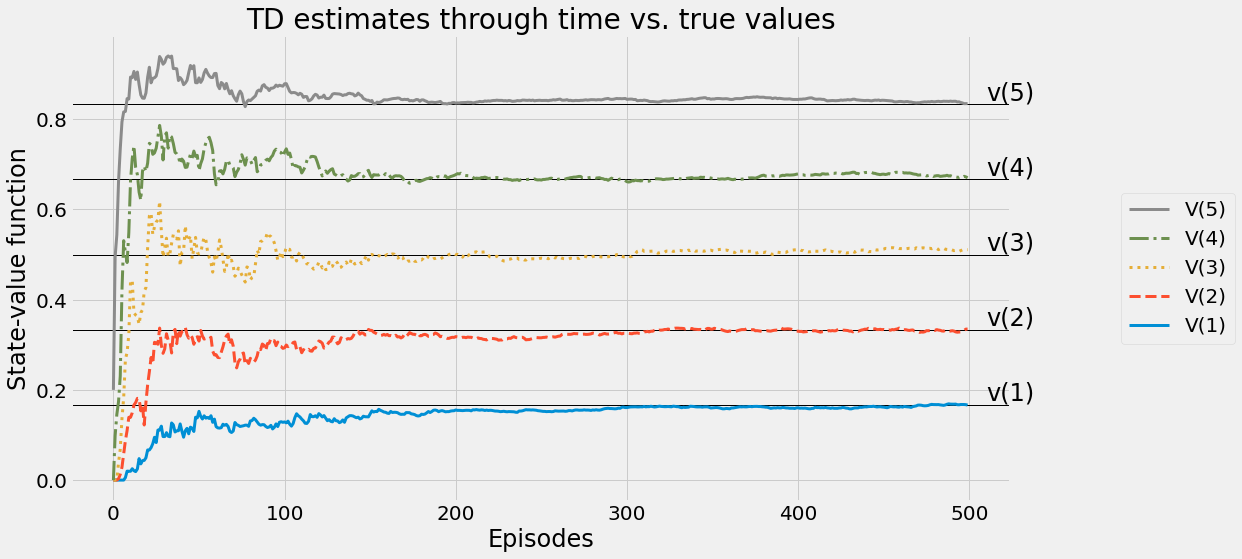

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

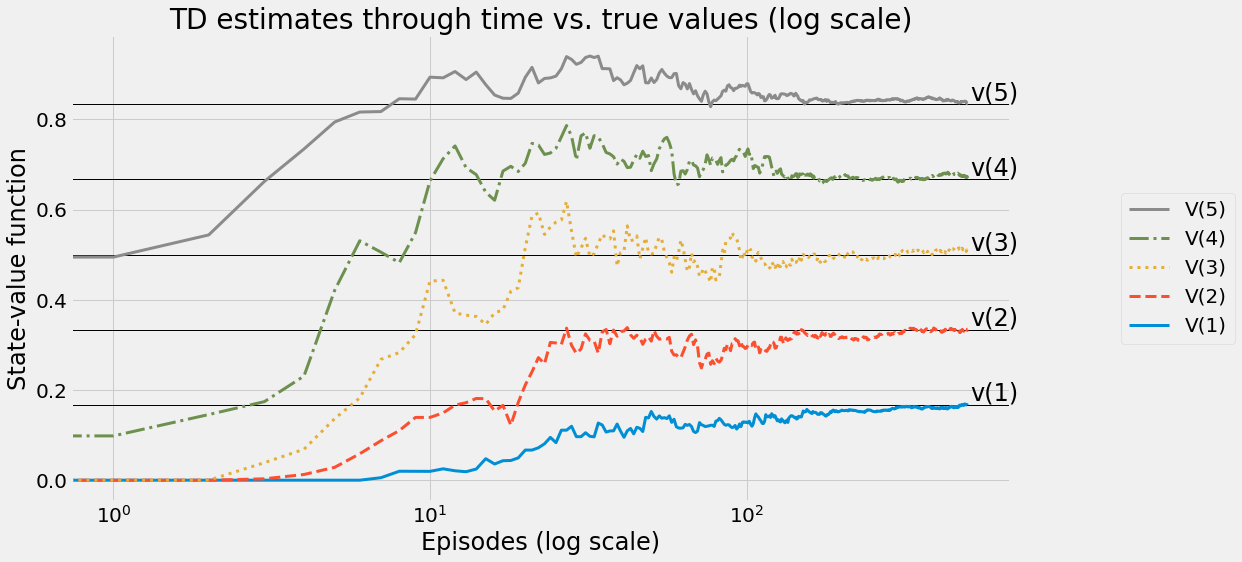

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

#### Comparing MC and TD

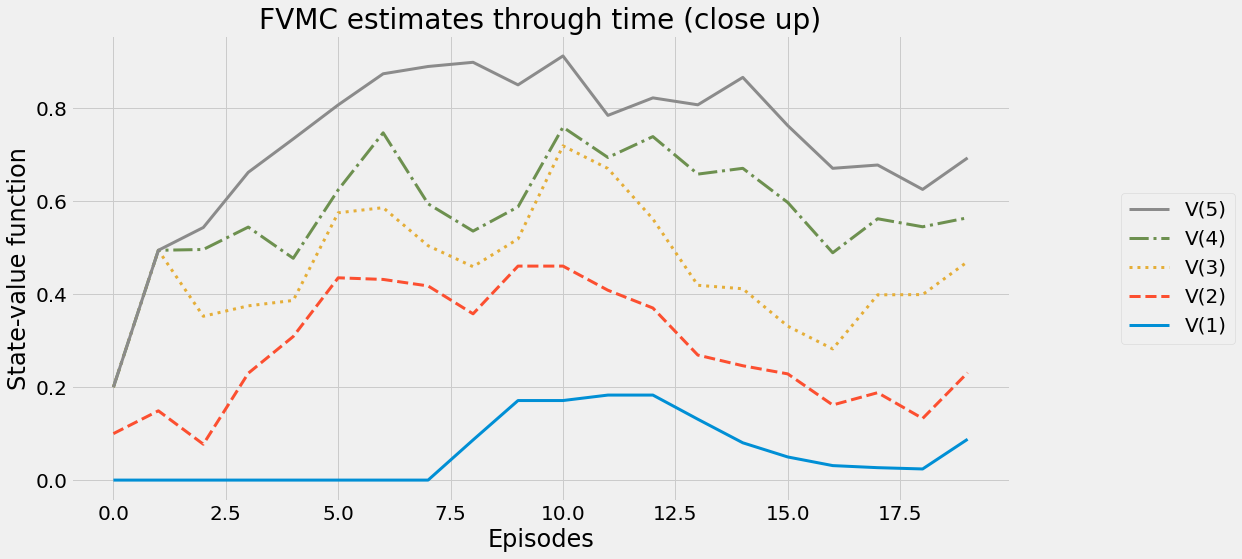

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:20], None, log=False)

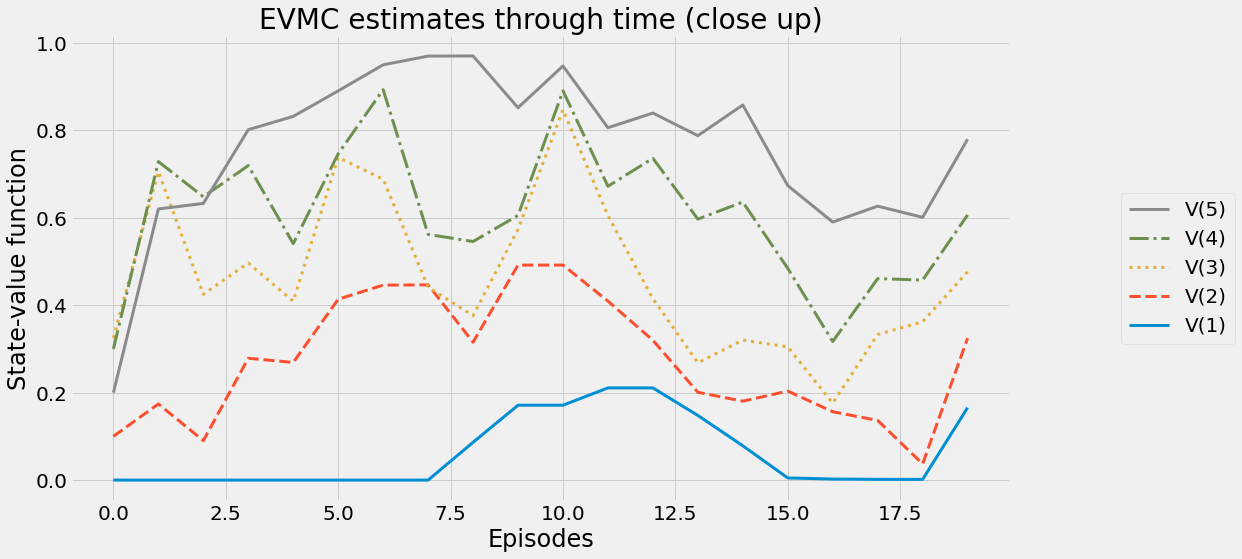

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:20], None, log=False)

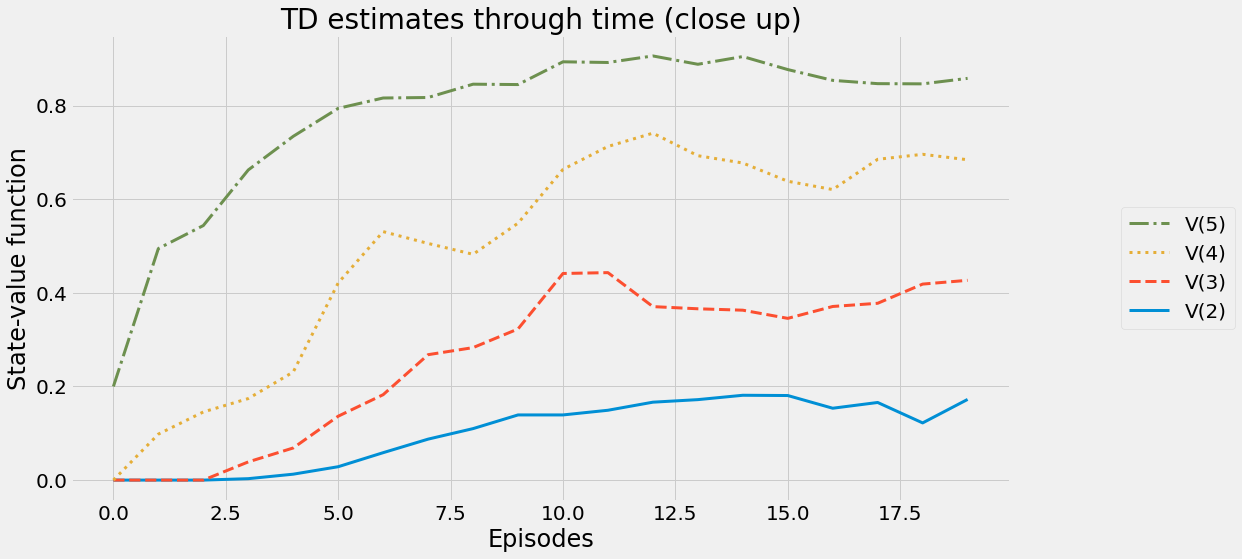

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

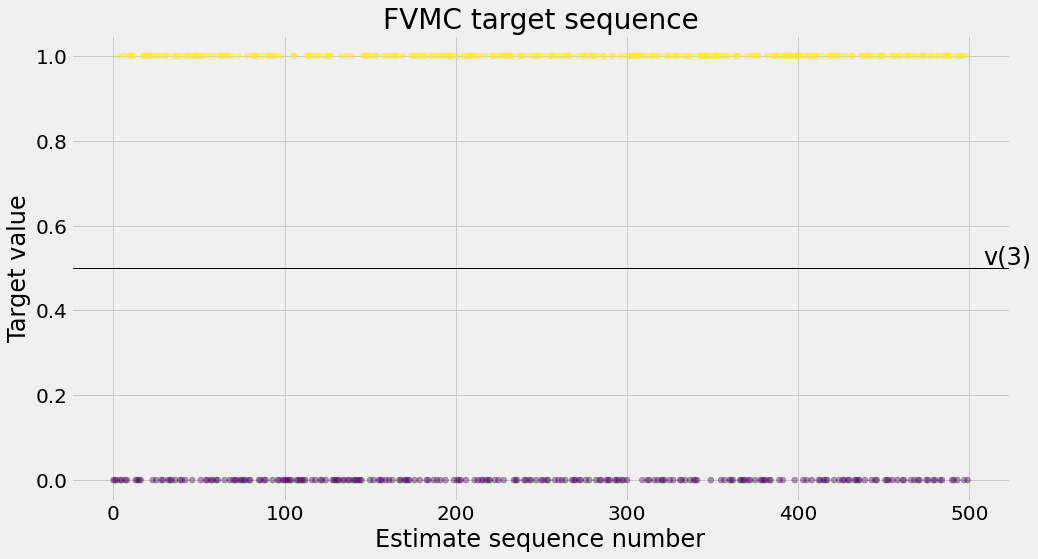

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

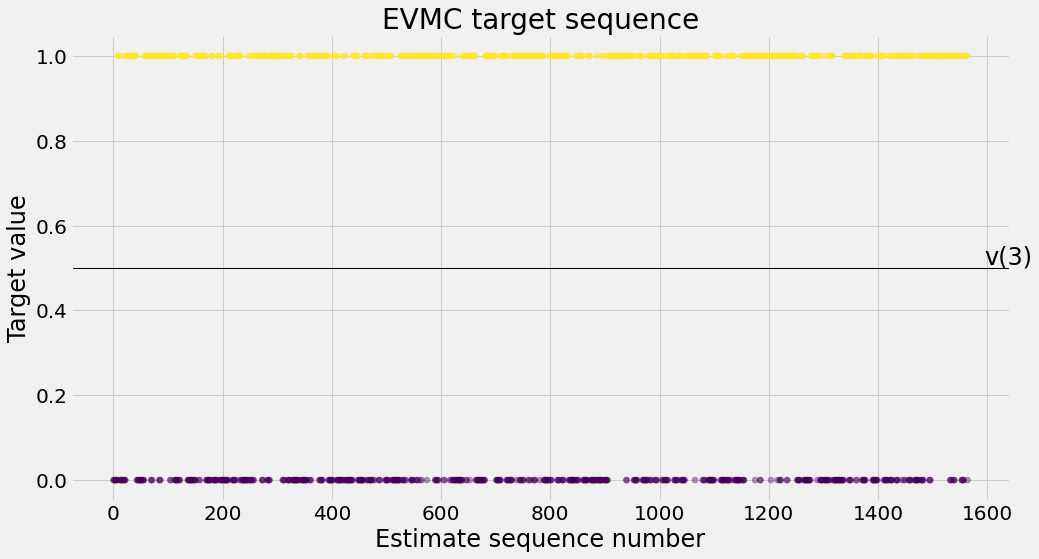

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

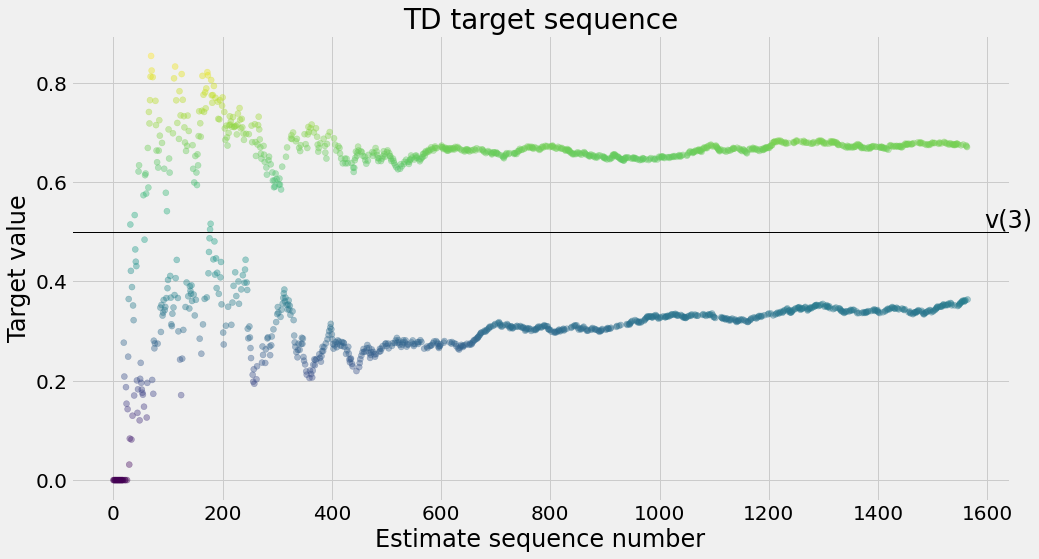

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')

#### n-step TD

In [ ]:
def ntd(pi, 
        env, 
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        n_step=3,
        n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    discounts = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False)
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done, path = env.reset(), False, []
        while not done or path is not None:
            path = path[1:]
            while not done and len(path) < n_step:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)
                experience = (state, reward, next_state, done)
                path.append(experience)
                state = next_state
                if done:
                    break

            n = len(path)
            est_state = path[0][0]
            rewards = np.array(path)[:,1]
            partial_return = discounts[:n] * rewards
            bs_val = discounts[-1] * V[next_state] * (not done)
            ntd_target = np.sum(np.append(partial_return, bs_val))
            ntd_error = ntd_target - V[est_state]
            V[est_state] = V[est_state] + alphas[e] * ntd_error
            if len(path) == 1 and path[0][3]:
                path = None

        V_track[e] = V
    return V, V_track

In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
|           | 01  0.174 | 02  0.344 | 03  0.516 | 04  0.673 | 05  0.826 |           |

State-value function errors:
|           | 01  0.007 | 02  0.011 | 03  0.016 | 04  0.006 | 05 -0.007 |           |
RMSE: 0.0087


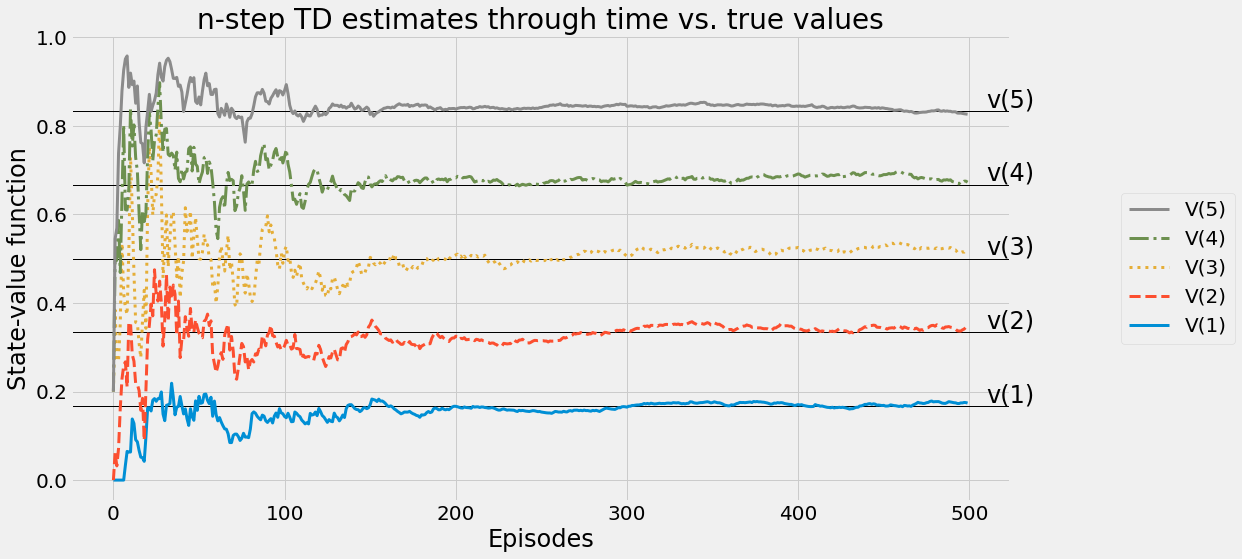

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

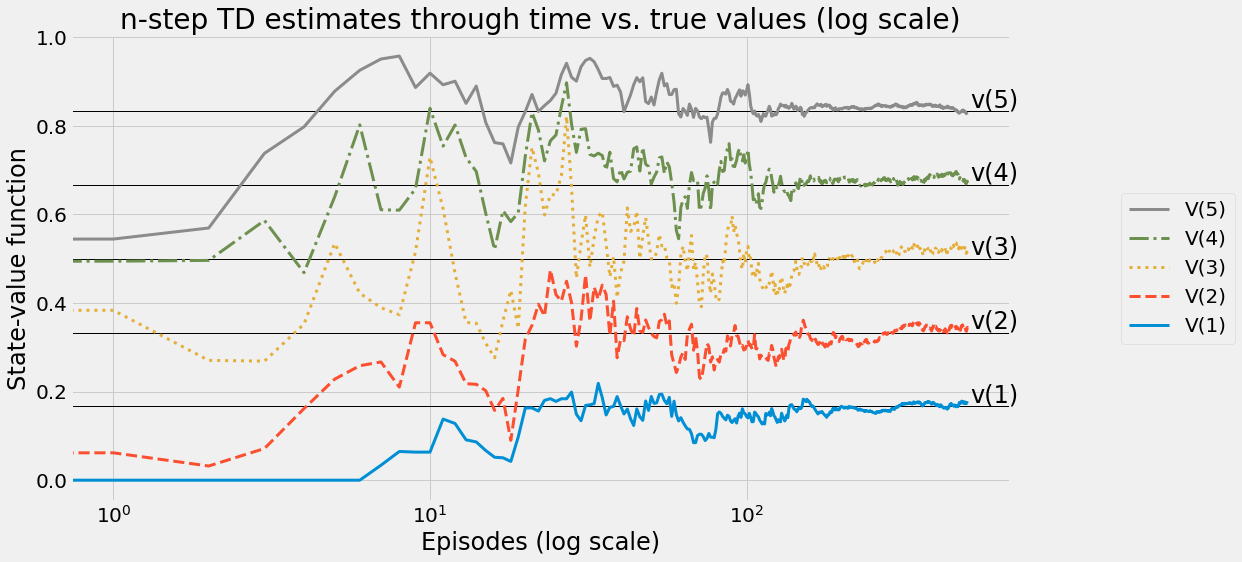

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

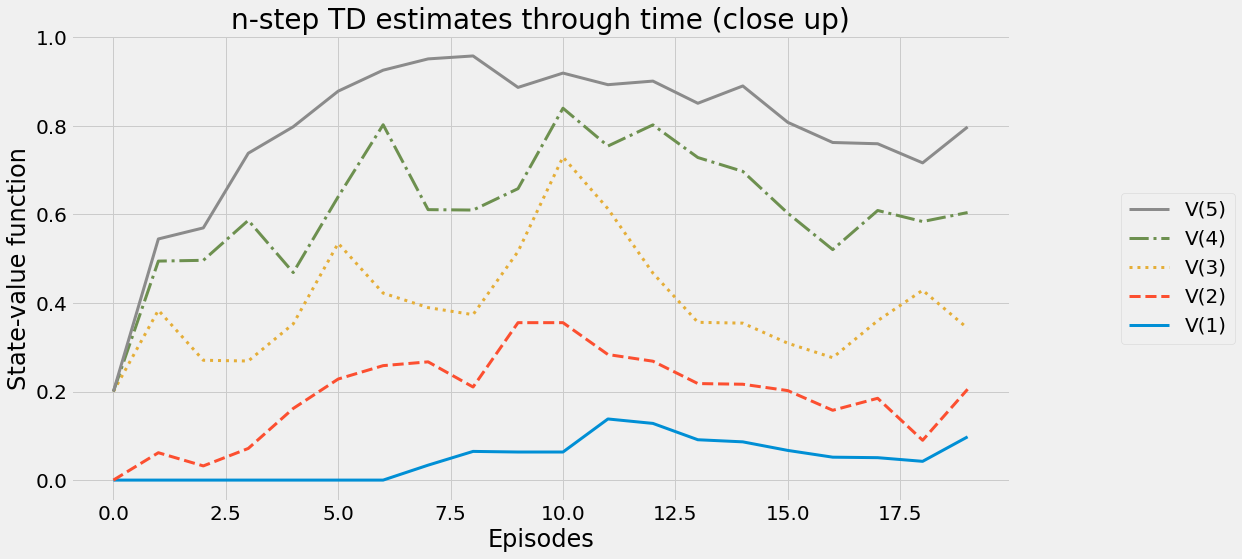

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

#### TD(λ)

In [ ]:
def td_lambda(pi, 
              env, 
              gamma=1.0,
              init_alpha=0.5,
              min_alpha=0.01,
              alpha_decay_ratio=0.5,
              lambda_=0.3,
              n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
|           | 01  0.169 | 02  0.338 | 03  0.512 | 04   0.67 | 05  0.833 |           |

State-value function errors:
|           | 01  0.002 | 02  0.005 | 03  0.012 | 04  0.003 | 05   -0.0 |           |
RMSE: 0.005


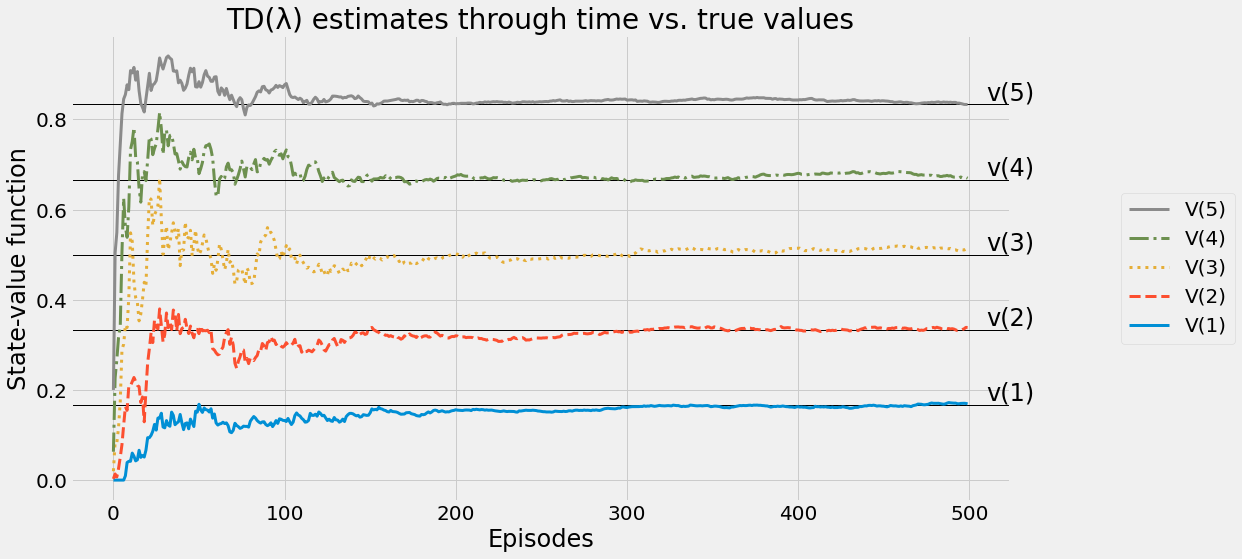

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

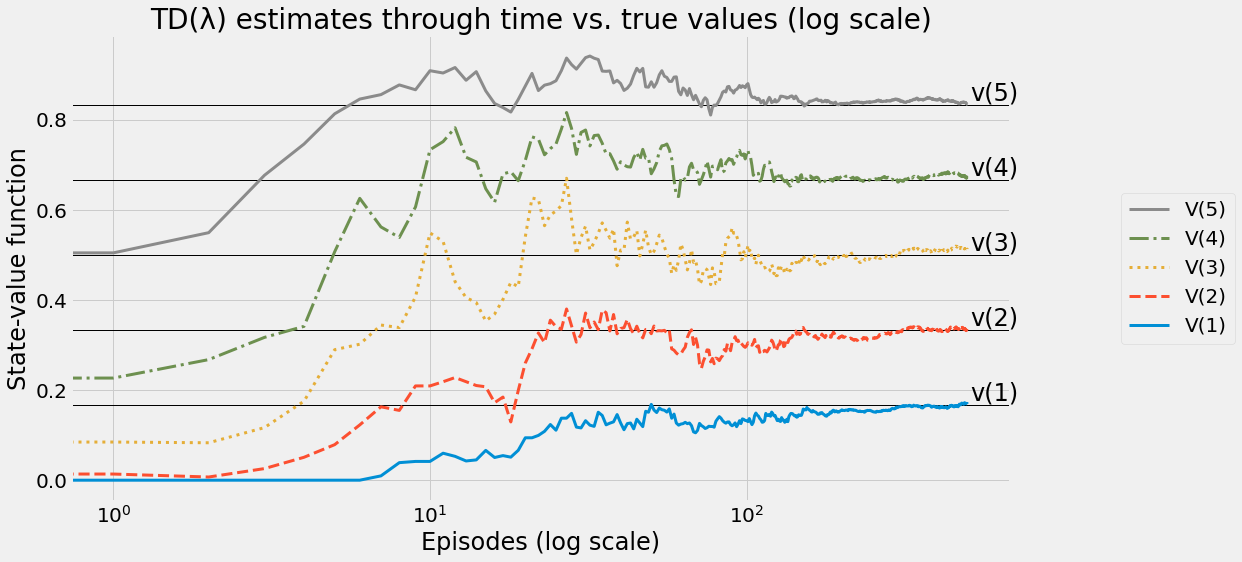

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

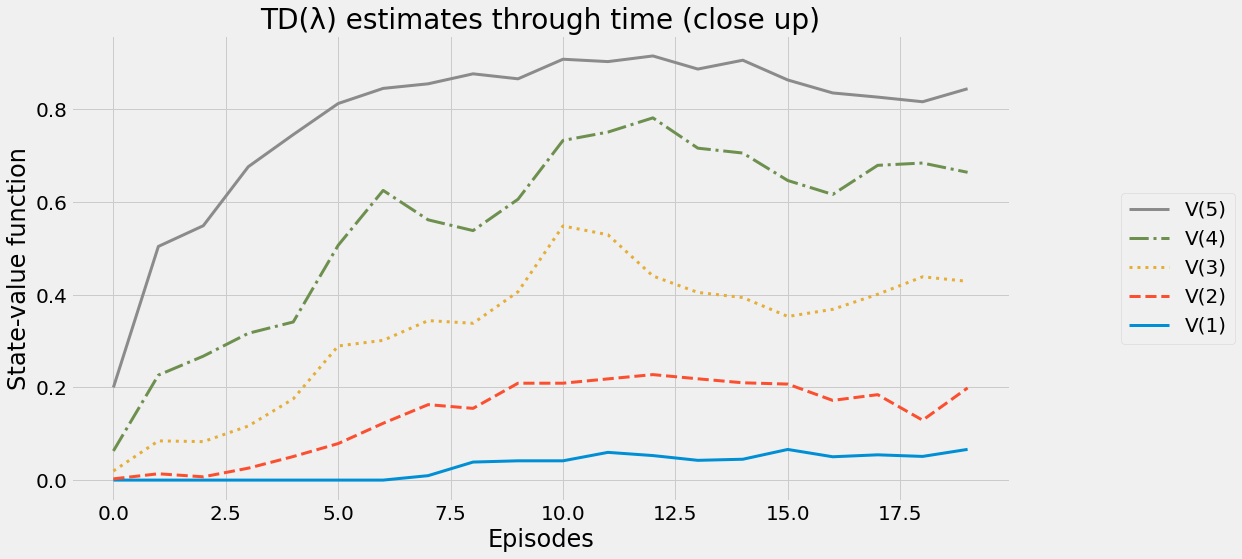

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)

### Russell & Norvig Gridworld environment and sample policy

In [ ]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 1000
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |

Policy:
| 00      > | 01      > | 02      > |           |
| 04      ^ |           | 06      ^ |           |
| 08      ^ | 09      < | 10      < | 11      < |
Reaches goal 96.00%. Obtains an average return of 0.6424.


#### Russell & Norvig Gridworld policy estimation (policy to state-value function)

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00   0.81 | 01  0.867 | 02  0.918 |           |
| 04  0.759 |           | 06  0.669 |           |
| 08  0.703 | 09  0.643 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.001 | 01 -0.001 | 02    0.0 |           |
| 04 -0.002 |           | 06  0.008 |           |
| 08 -0.002 | 09 -0.012 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2091


In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00  0.809 | 01  0.867 | 02  0.918 |           |
| 04  0.748 |           | 06   0.68 |           |
| 08  0.696 | 09  0.636 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.003 | 01   -0.0 | 02  0.001 |           |
| 04 -0.013 |           | 06   0.02 |           |
| 08 -0.009 | 09 -0.019 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2092


In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.811 | 01  0.867 | 02  0.913 |           |
| 04  0.761 |           | 06  0.651 |           |
| 08  0.704 | 09  0.643 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.001 | 01 -0.001 | 02 -0.005 |           |
| 04 -0.001 |           | 06  -0.01 |           |
| 08 -0.001 | 09 -0.012 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2091


In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.808 | 01  0.868 | 02  0.915 |           |
| 04  0.763 |           | 06  0.674 |           |
| 08  0.705 | 09  0.659 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.003 | 01    0.0 | 02 -0.002 |           |
| 04  0.001 |           | 06  0.014 |           |
| 08    0.0 | 09  0.004 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2091


In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.811 | 01  0.867 | 02  0.915 |           |
| 04  0.761 |           | 06  0.655 |           |
| 08  0.706 | 09  0.651 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00   -0.0 | 01 -0.001 | 02 -0.003 |           |
| 04   -0.0 |           | 06 -0.005 |           |
| 08  0.001 | 09 -0.004 | 10 -0.611 | 11 -0.388 |
RMSE: 0.209


#### Russell & Norvig Gridworld state-value function estimation

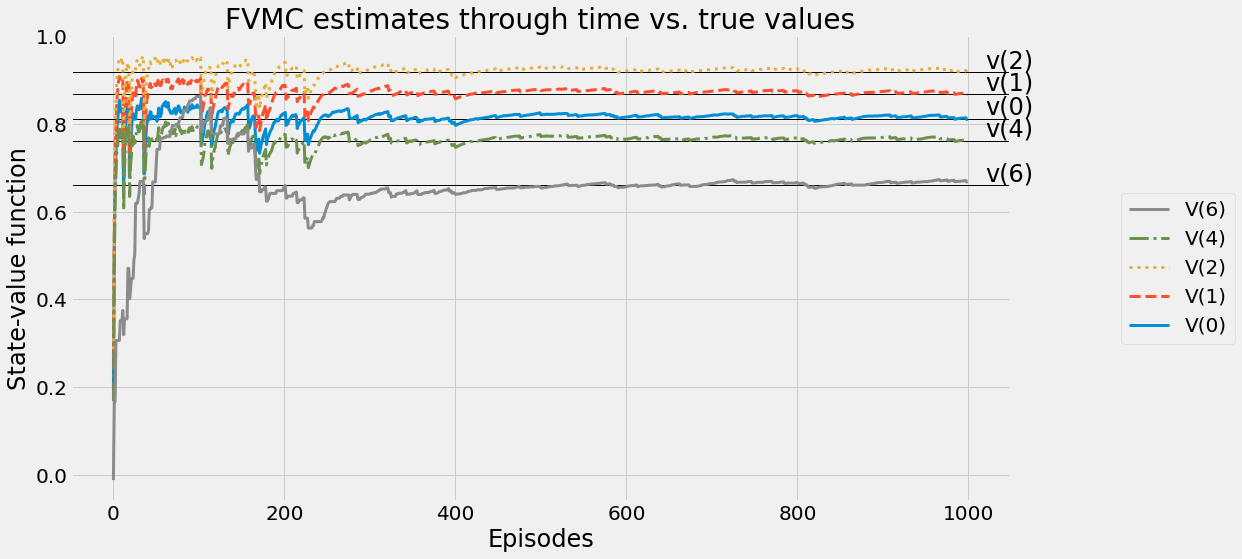

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

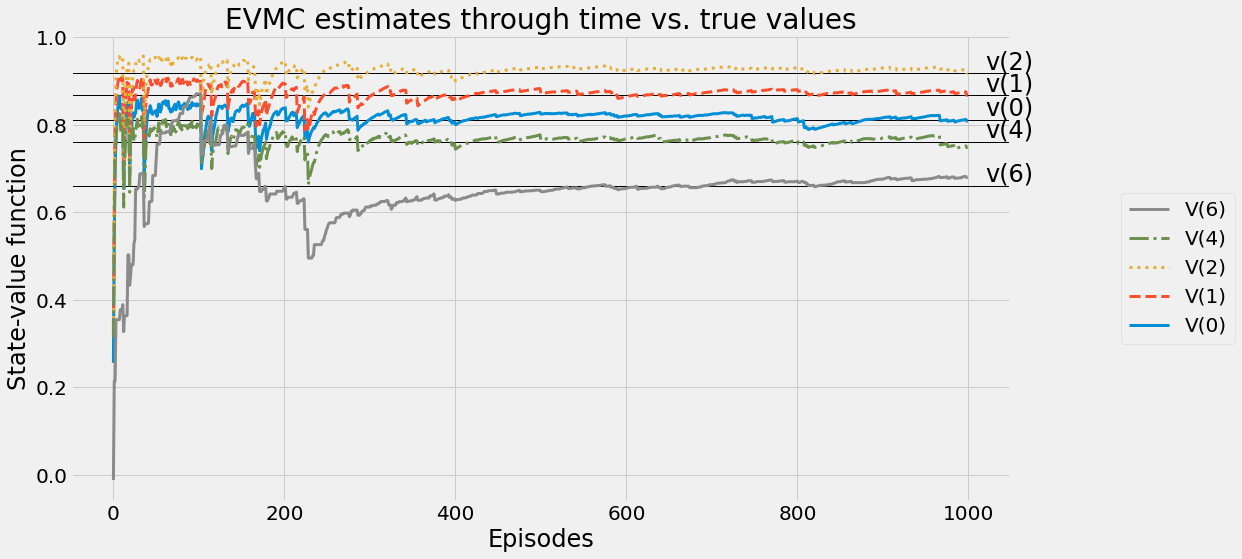

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

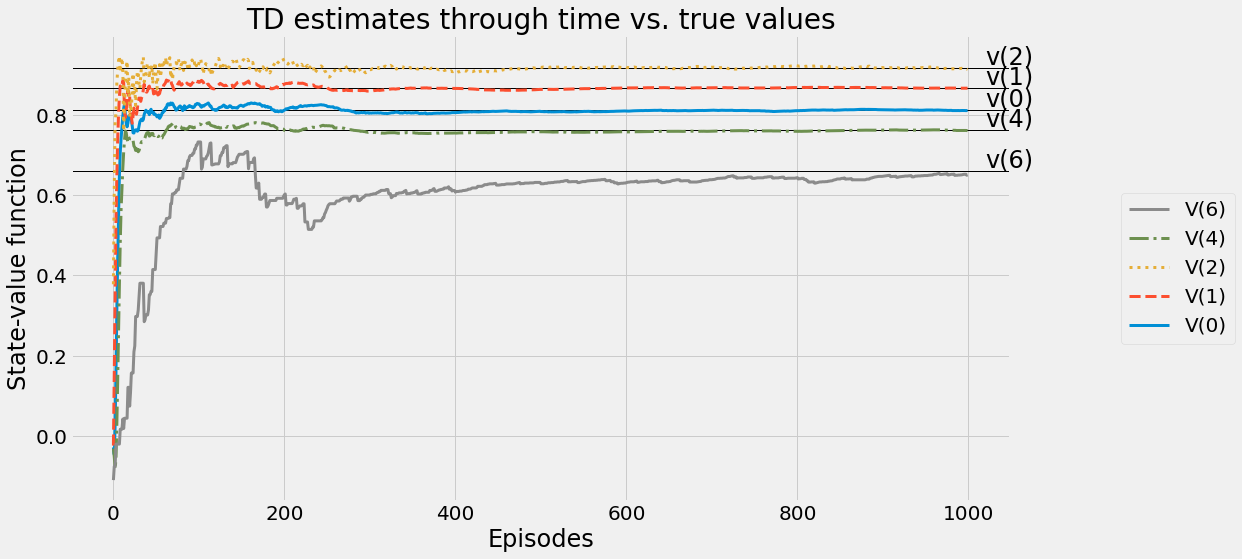

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

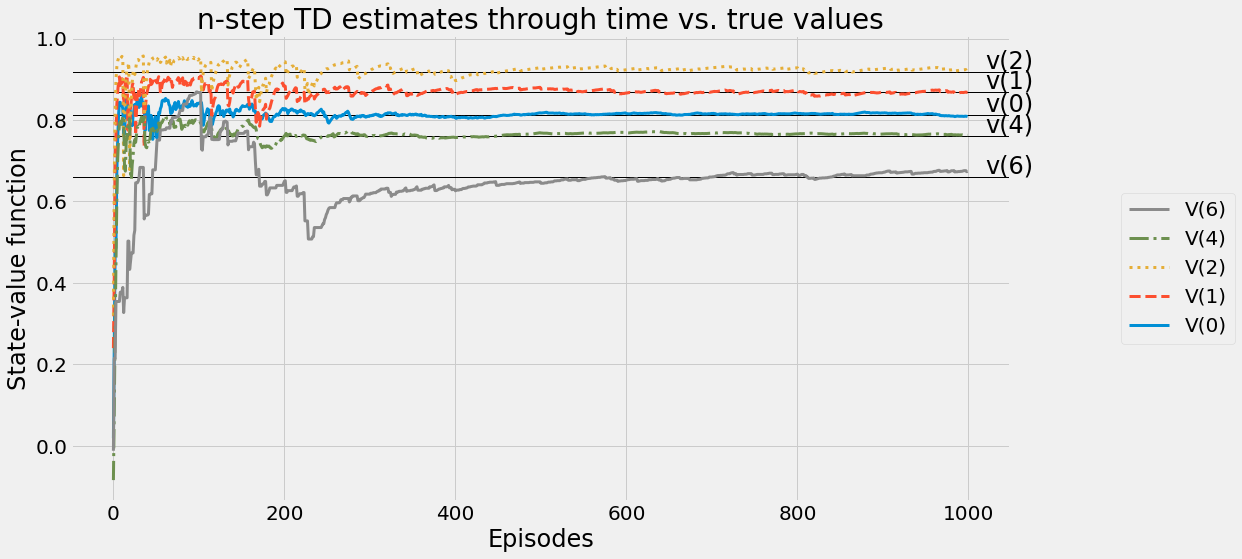

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

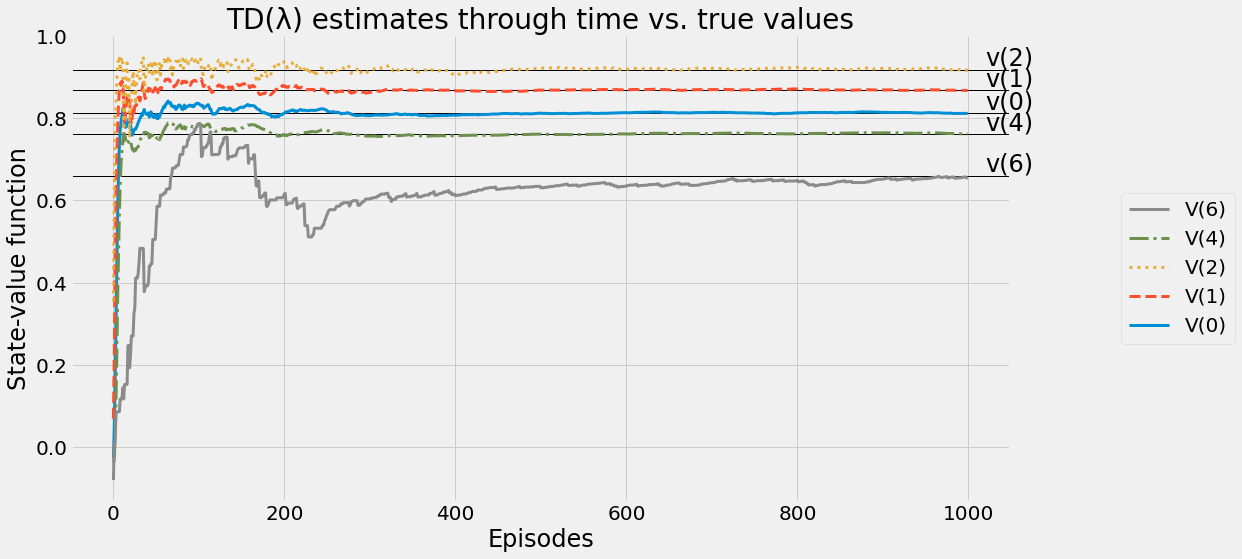

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

#### Russell & Norvig Gridworld state-value function estimation (x axis in log scale)

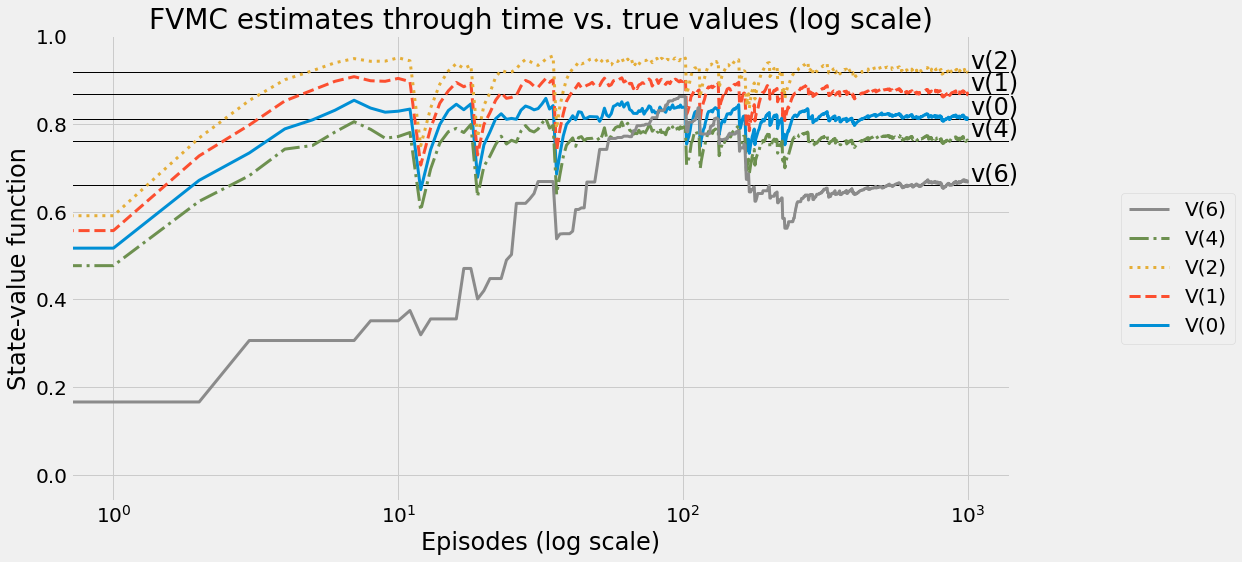

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

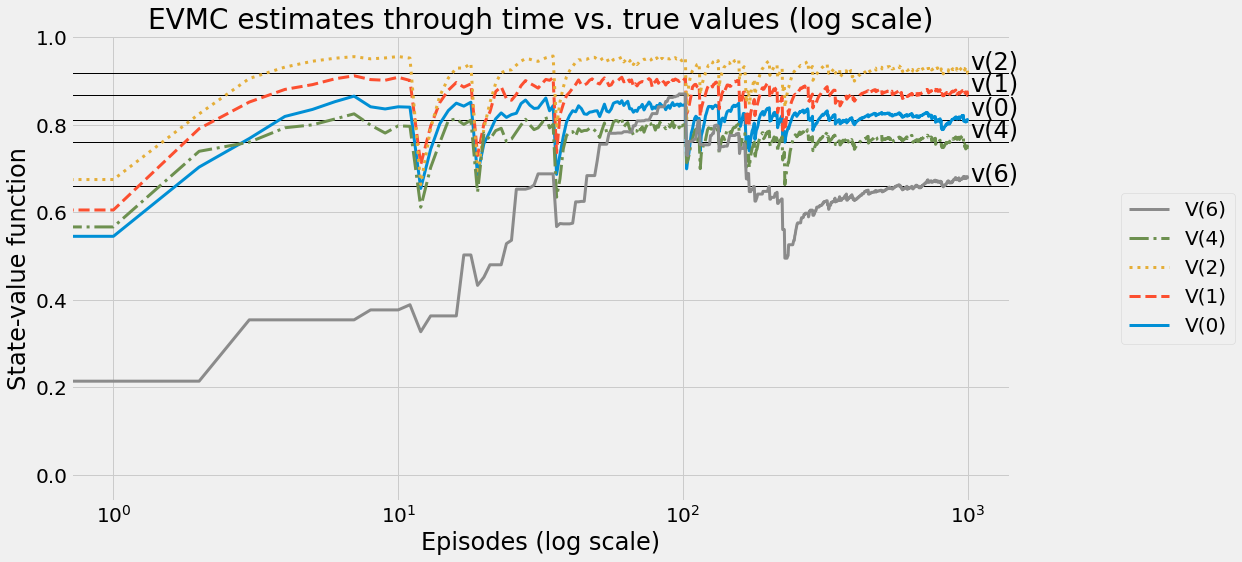

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

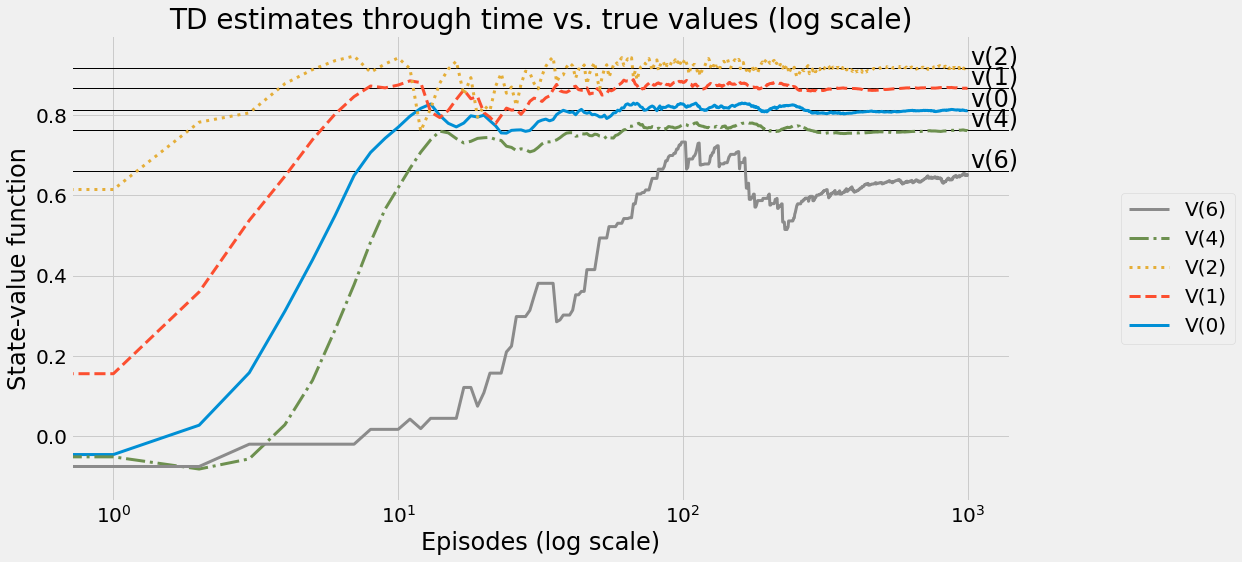

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

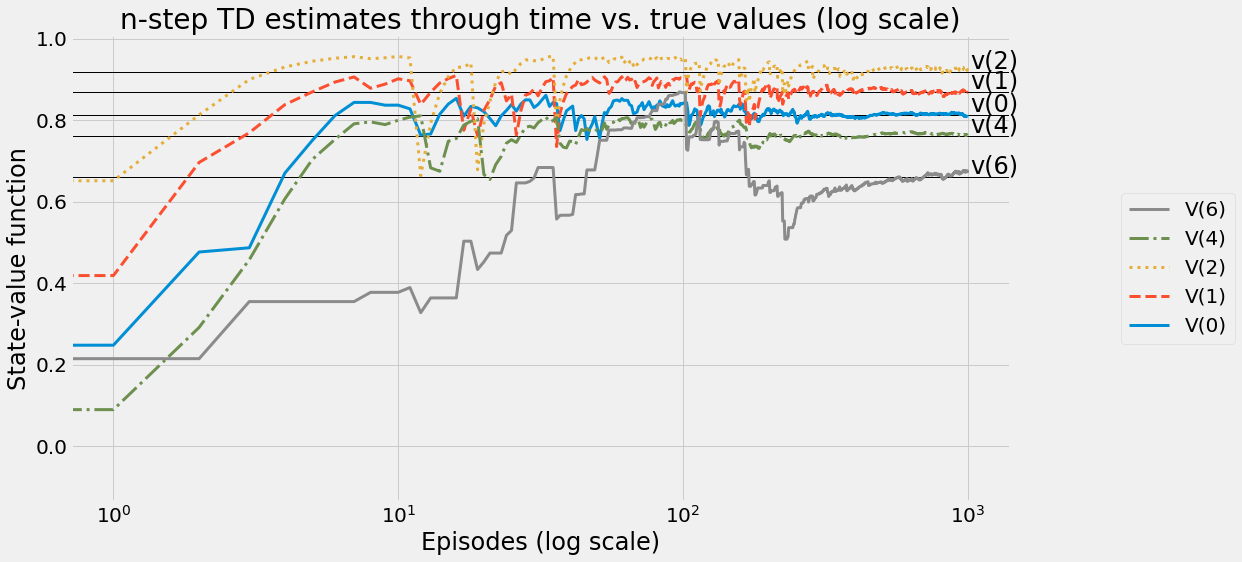

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

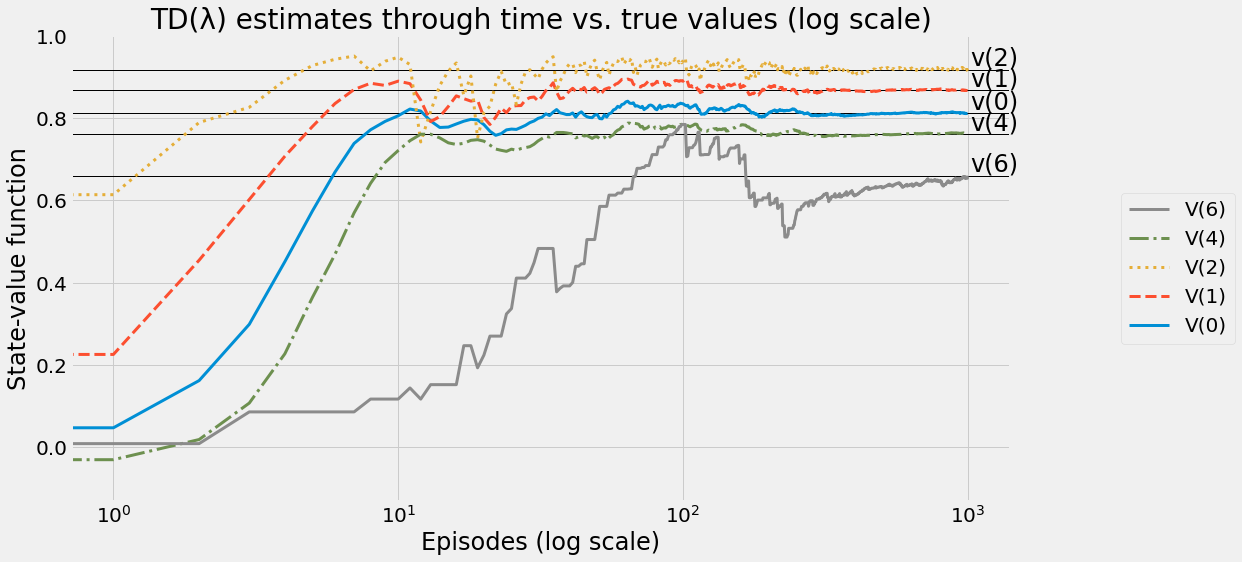

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

#### Close ups

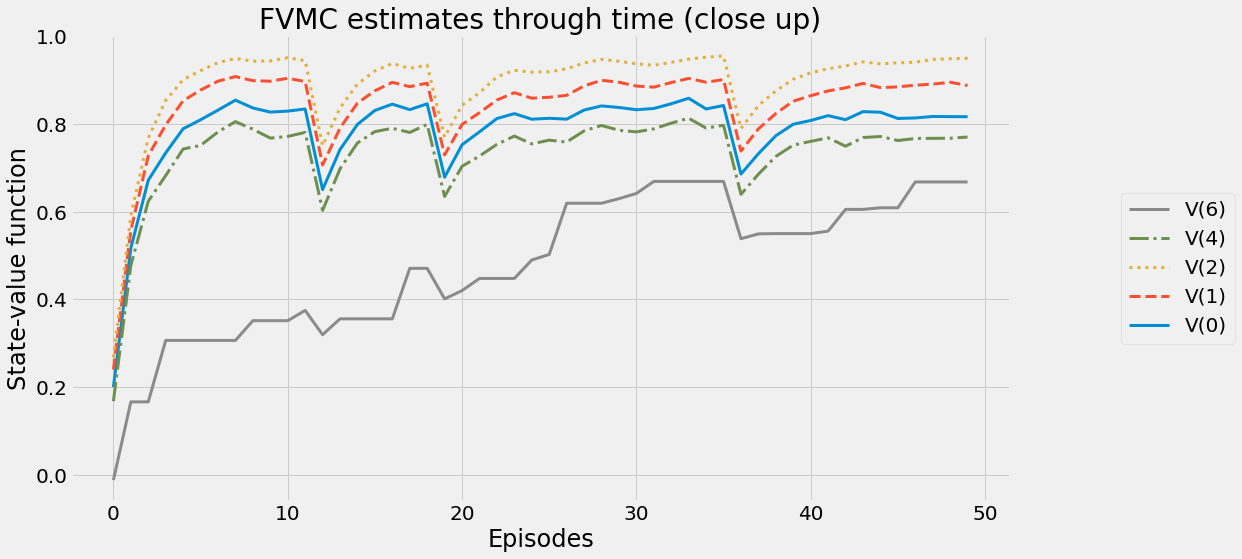

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:50], None, log=False)

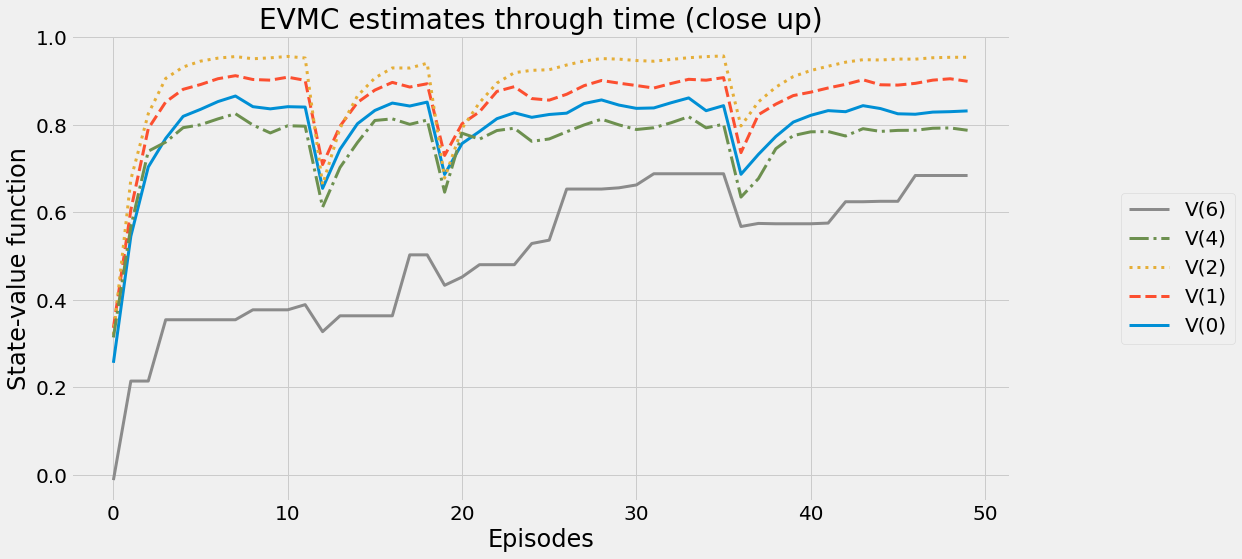

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:50], None, log=False)

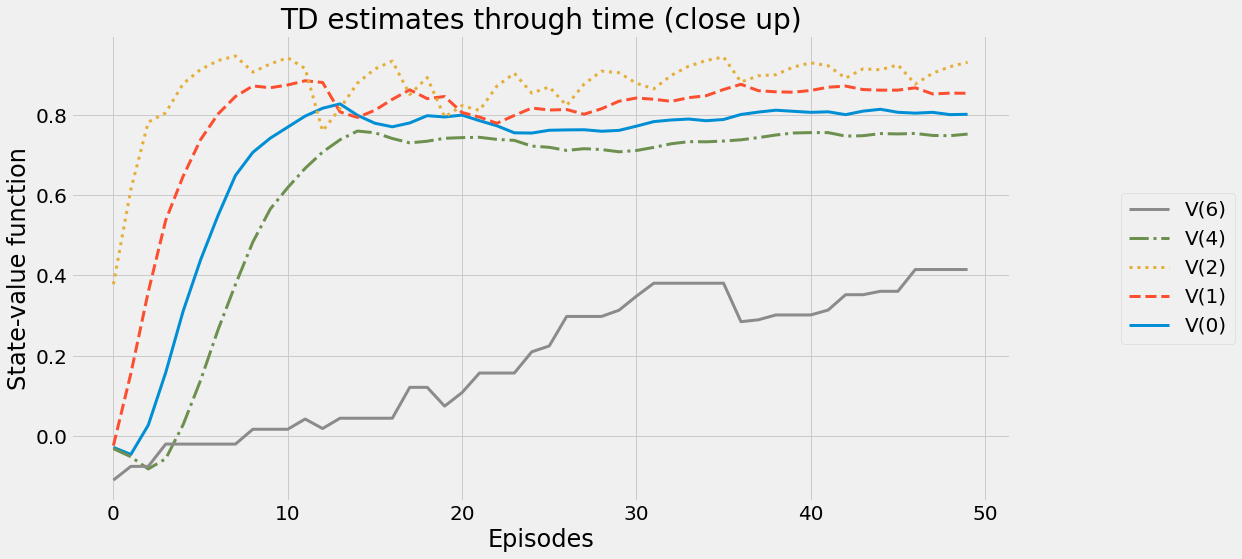

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:50], None, log=False)

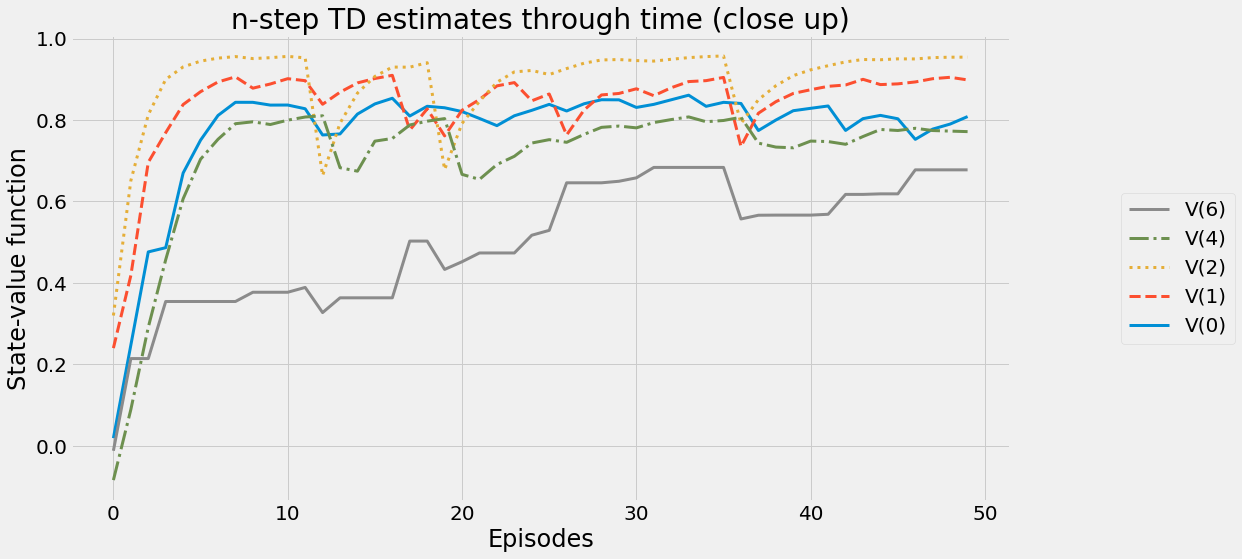

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:50], None, log=False)

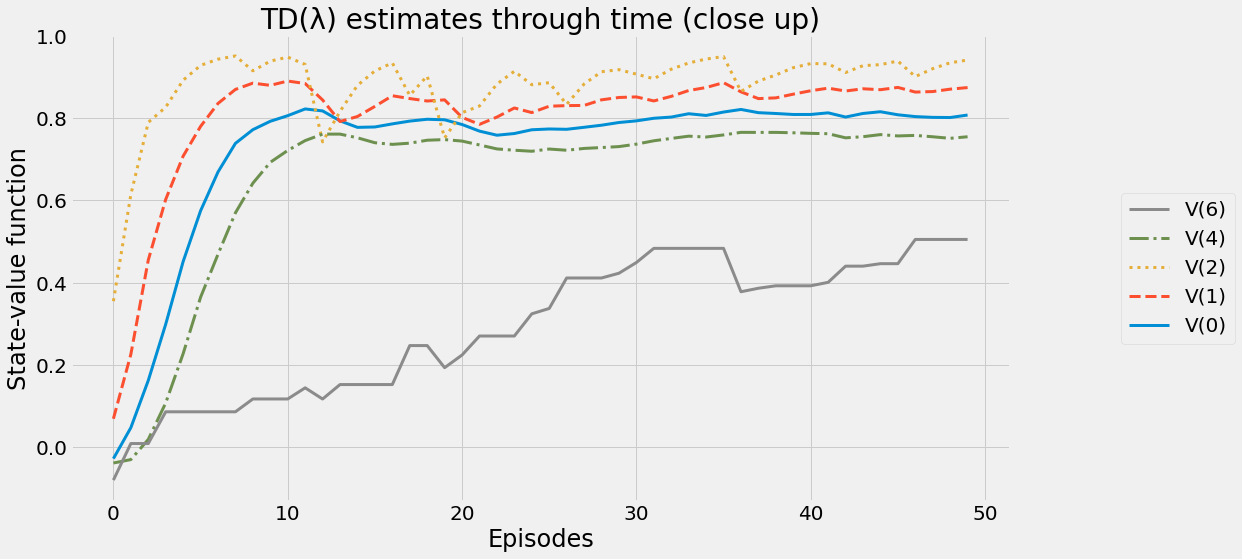

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:50], None, log=False)

#### MC vs. TD

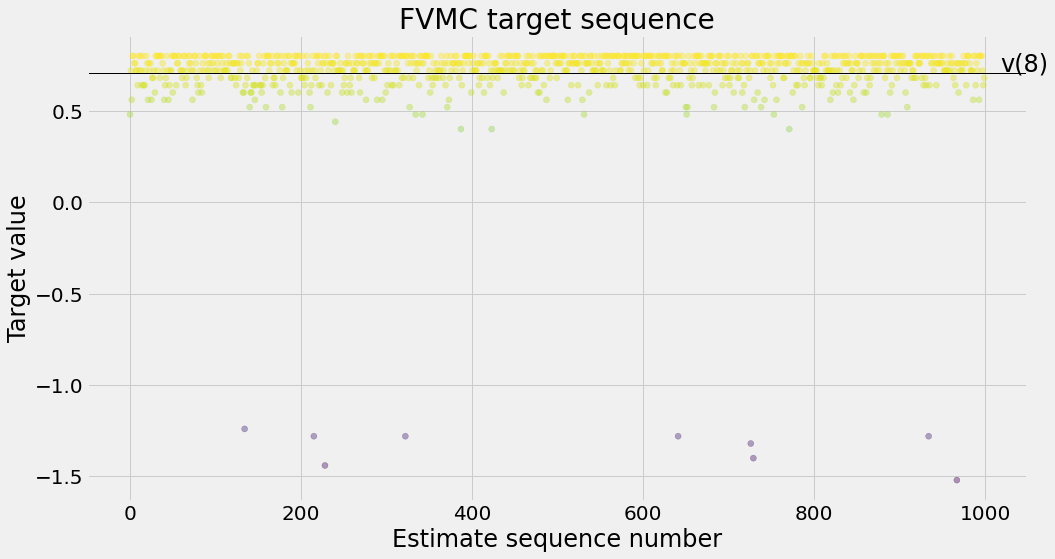

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

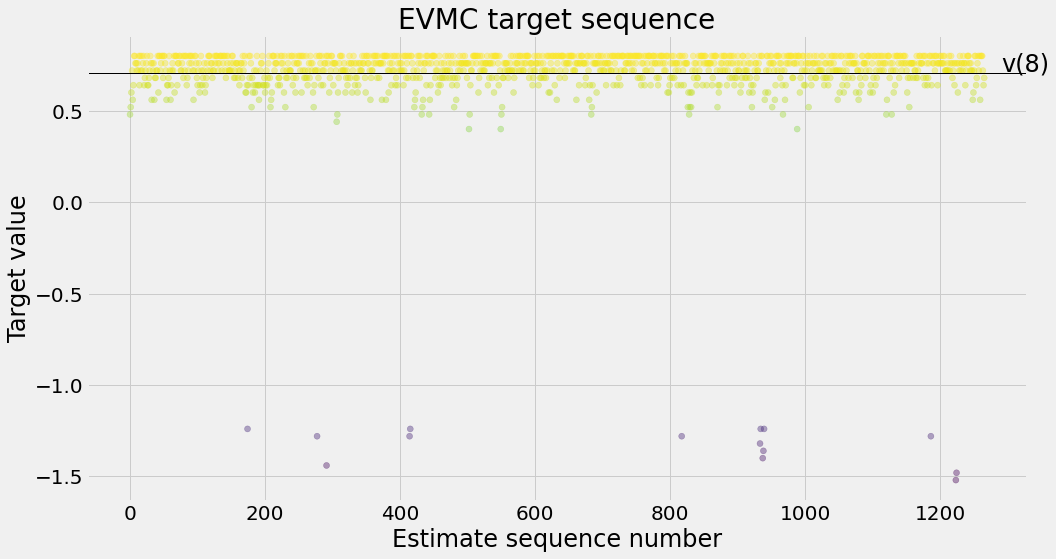

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

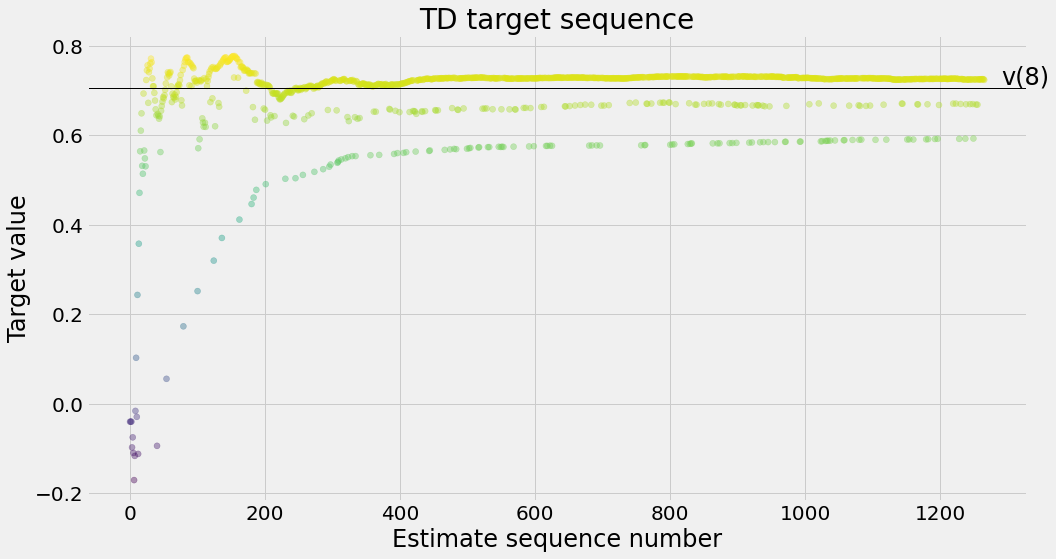

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')

### FrozenLake environment and sample policy

In [ ]:
env = gym.make('FrozenLake-v0')
init_state = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 2500
P = env.env.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:LEFT,   1:UP,     2:UP,    3:UP,
    4:LEFT,   5:LEFT,   6:LEFT,  7:LEFT,
    8:UP,     9:DOWN,  10:LEFT, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |

Policy:
| 00      < | 01      ^ | 02      ^ | 03      ^ |
| 04      < |           | 06      < |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |
Reaches goal 74.00%. Obtains an average return of 0.5116.


#### FrozenLake policy estimation (policy to state-value function)

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00  0.528 | 01  0.359 | 02  0.336 | 03  0.313 |
| 04  0.544 |           | 06  0.296 |           |
| 08  0.575 | 09  0.618 | 10  0.579 |           |
|           | 13  0.712 | 14  0.841 |           |

State-value function errors:
| 00 -0.014 | 01  -0.14 | 02 -0.135 | 03 -0.143 |
| 04 -0.014 |           | 06 -0.063 |           |
| 08 -0.016 | 09 -0.025 | 10 -0.037 |           |
|           | 13  -0.03 | 14 -0.022 |           |
RMSE: 0.0643


In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00  0.456 | 01  0.323 | 02  0.278 | 03  0.277 |
| 04   0.49 |           | 06  0.277 |           |
| 08  0.519 | 09  0.561 | 10  0.531 |           |
|           | 13  0.668 | 14  0.836 |           |

State-value function errors:
| 00 -0.086 | 01 -0.176 | 02 -0.192 | 03 -0.179 |
| 04 -0.069 |           | 06 -0.082 |           |
| 08 -0.072 | 09 -0.082 | 10 -0.084 |           |
|           | 13 -0.074 | 14 -0.027 |           |
RMSE: 0.095


In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.508 | 01  0.451 | 02  0.417 | 03  0.401 |
| 04  0.527 |           | 06  0.337 |           |
| 08  0.566 | 09   0.62 | 10  0.592 |           |
|           | 13  0.722 | 14  0.851 |           |

State-value function errors:
| 00 -0.034 | 01 -0.048 | 02 -0.054 | 03 -0.056 |
| 04 -0.031 |           | 06 -0.021 |           |
| 08 -0.025 | 09 -0.023 | 10 -0.023 |           |
|           | 13  -0.02 | 14 -0.012 |           |
RMSE: 0.0287


In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.517 | 01  0.453 | 02  0.419 | 03  0.402 |
| 04  0.535 |           | 06  0.334 |           |
| 08   0.57 | 09   0.62 | 10  0.585 |           |
|           | 13  0.717 | 14  0.849 |           |

State-value function errors:
| 00 -0.025 | 01 -0.046 | 02 -0.051 | 03 -0.055 |
| 04 -0.023 |           | 06 -0.024 |           |
| 08 -0.021 | 09 -0.023 | 10  -0.03 |           |
|           | 13 -0.025 | 14 -0.014 |           |
RMSE: 0.0276


In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

#### FrozenLake state-value function estimation

In [ ]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

In [ ]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

#### FrozenLake state-value function estimation (x axis in log scale)

In [ ]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

In [ ]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

In [ ]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

In [ ]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

In [ ]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

#### Close ups

In [ ]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:100], None, log=False)

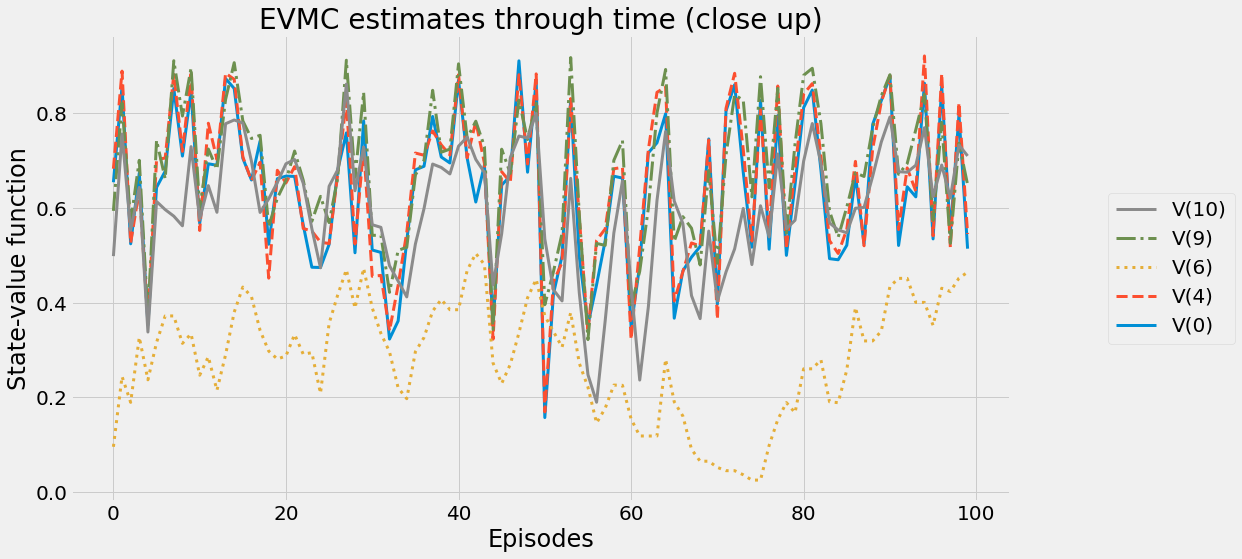

In [ ]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:100], None, log=False)

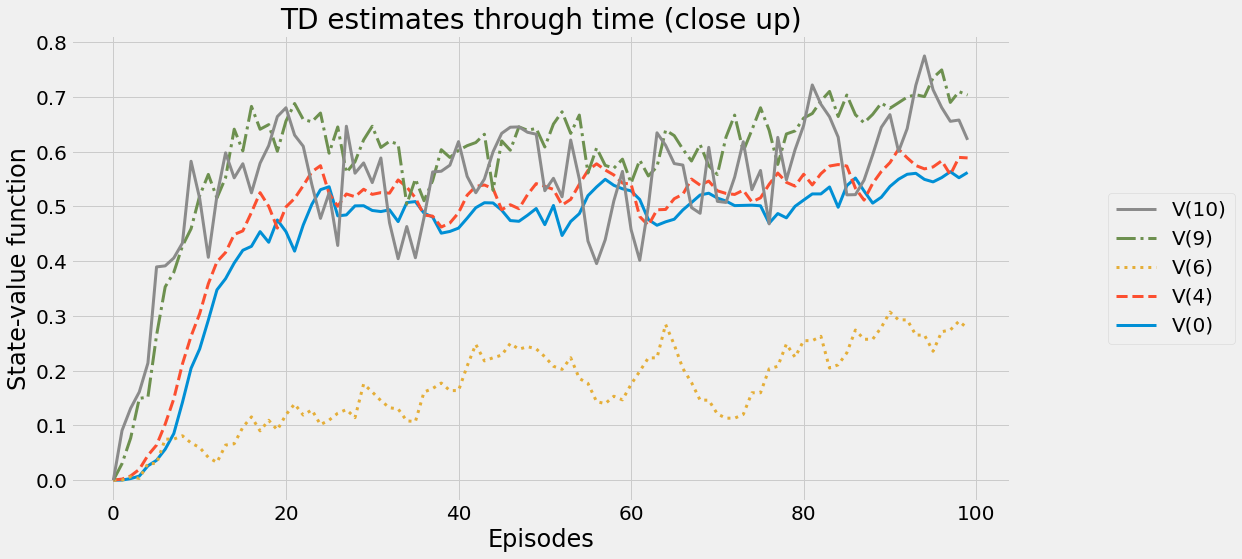

In [ ]:
plot_value_function('TD estimates through time (close up)', V_track_td[:100], None, log=False)

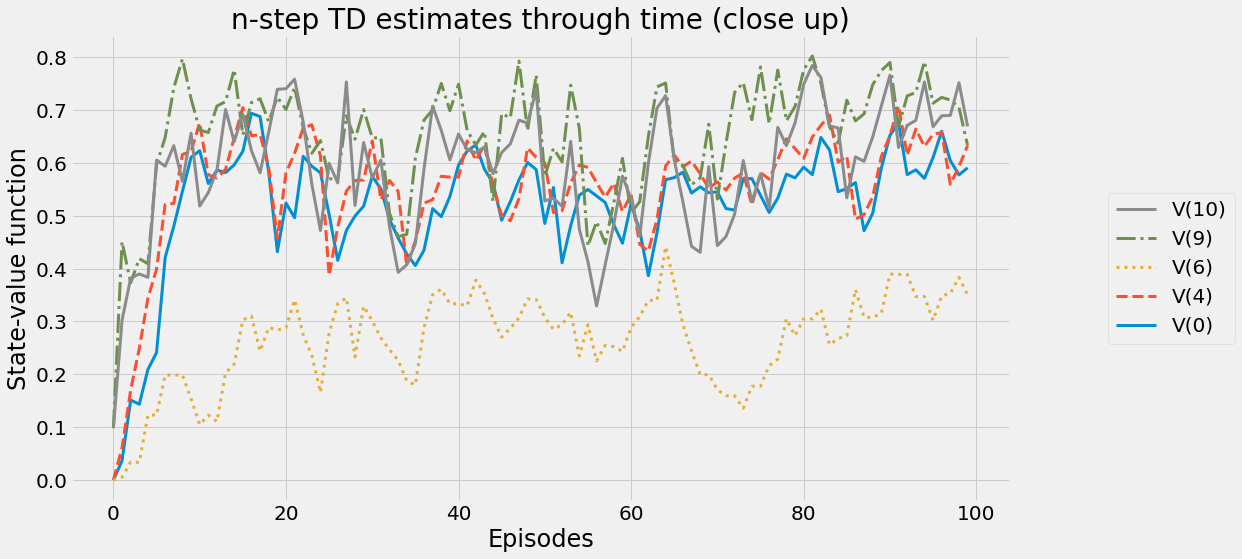

In [ ]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:100], None, log=False)

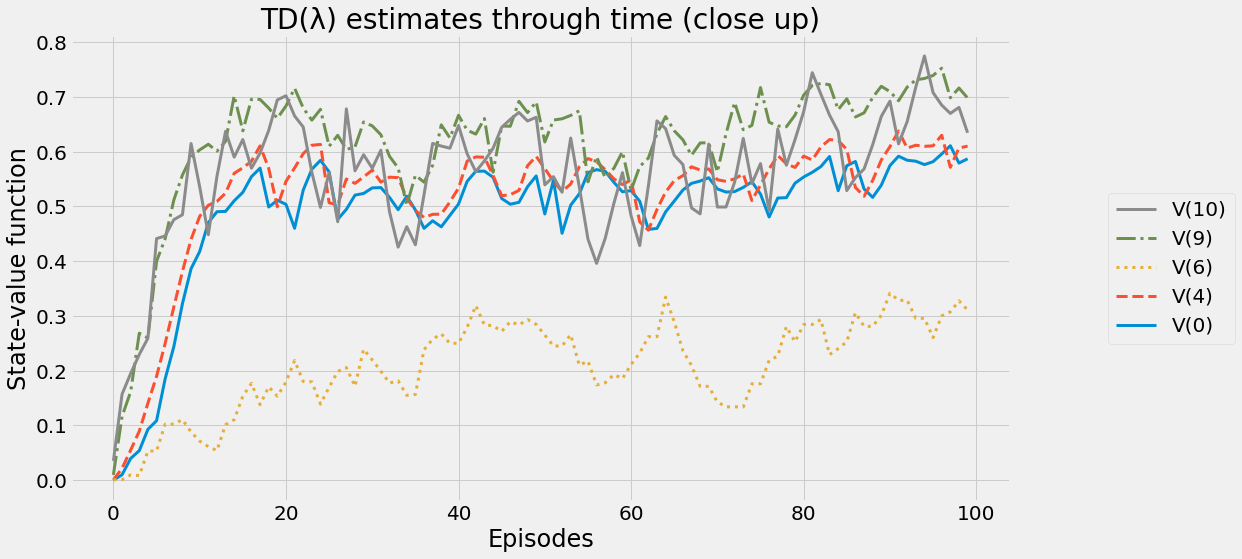

In [ ]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:100], None, log=False)

#### MC vs. TD

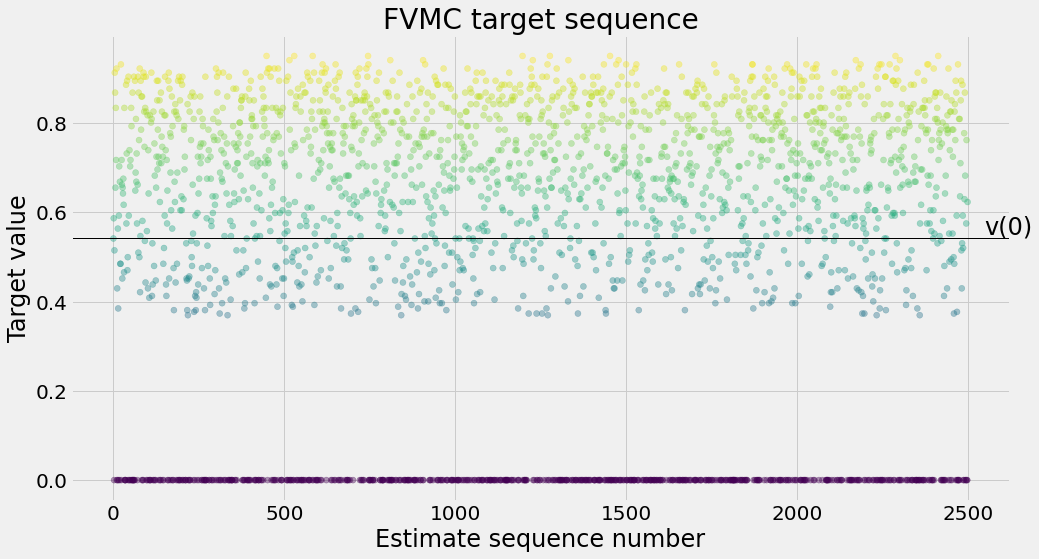

In [ ]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

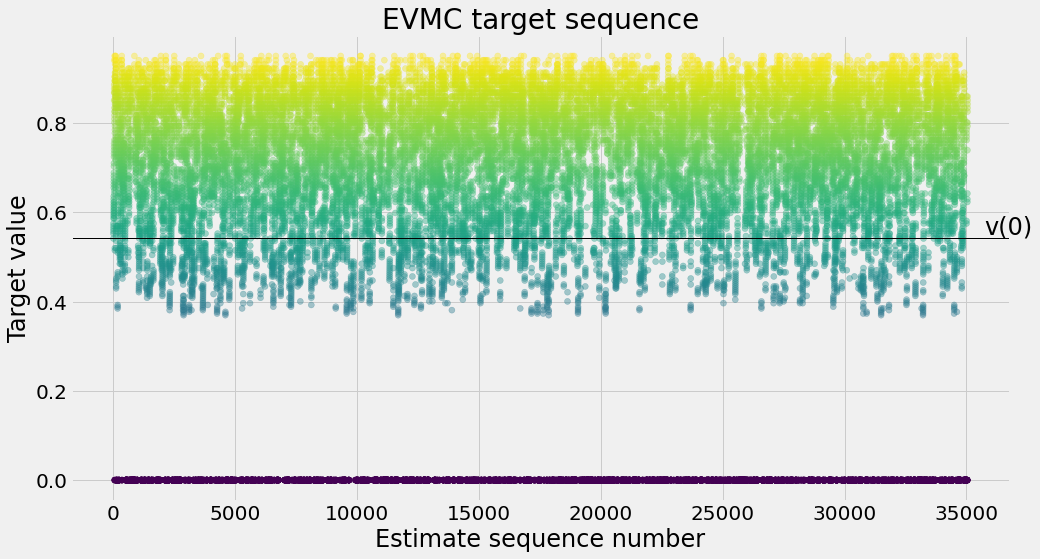

In [ ]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

In [ ]:
plot_targets(targets_td, init_state, title='TD target sequence')